In [1]:
# Importing libraries 
import sys
import h5py
import warnings
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conventional ML Model Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Neural Network Libraries
from tensorflow.keras import utils, losses, optimizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, ReLU, Dense, BatchNormalization   

In [0]:
# Configuring for any default setting of any library
np.random.seed(5)
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

**Loading and Visualising the data** 

In [3]:
svhn_file = 'SVHN_single_grey1.h5'
if 'google.colab' in sys.modules:    
    # Google Colab lib
    from google.colab import drive
    # Mount the drive
    drive.mount('/content/drive/')
    # Open the drive file as read only
    svhn = h5py.File('/content/drive/My Drive/' + svhn_file, 'r')
    
else:
    # Open the local file as read only
    svhn = h5py.File(svhn_file, 'r')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
# Load the training, validation and test sets
X_train_df = svhn['X_train'][:]
X_test_df = svhn['X_test'][:]
X_val_df = svhn['X_val'][:]
y_train_df = svhn['y_train'][:]
y_test_df = svhn['y_test'][:]
y_val_df = svhn['y_val'][:]

print('Shape of different datasets are:')
print('X_train :', X_train_df.shape)
print('X_test  :', X_test_df.shape)
print('X_val   :', X_val_df.shape)
print('y_train :', y_train_df.shape)
print('y_test  :', y_test_df.shape)
print('y_val   :', y_val_df.shape)

Shape of different datasets are:
X_train : (42000, 32, 32)
X_test  : (18000, 32, 32)
X_val   : (60000, 32, 32)
y_train : (42000,)
y_test  : (18000,)
y_val   : (60000,)


Labels corresponding to below images: [2 6 7 4 4 0 3 0 7 3 1 0 1 3 1]


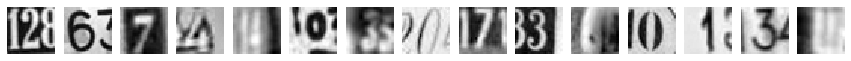

In [5]:
# Visualizing the first 15 images in the dataset and their labels
print('Labels corresponding to below images: %s' % (y_train_df[0:15]))
plt.figure(figsize=(15, 1))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_train_df[i], cmap="gray")
    plt.axis('off')

**Preprocessing the Image**

In [6]:
# Flatten the X_* datasets
X_train_flatten = X_train_df.reshape(X_train_df.shape[0], X_train_df.shape[1] * X_train_df.shape[2]).astype('float32')
X_test_flatten = X_test_df.reshape(X_test_df.shape[0], X_test_df.shape[1] * X_test_df.shape[2]).astype('float32')
X_val_flatten = X_val_df.reshape(X_val_df.shape[0], X_val_df.shape[1] * X_val_df.shape[2]).astype('float32')

print('Shape after flattening:')
print('X_train :', X_train_flatten.shape)
print('X_test  :', X_test_flatten.shape)
print('X_val   :', X_val_flatten.shape)

Shape after flattening:
X_train : (42000, 1024)
X_test  : (18000, 1024)
X_val   : (60000, 1024)


In [7]:
# Normalize the inputs from 0-255 to 0-1
X_train = X_train_flatten / 255.0
X_test = X_test_flatten / 255.0
X_val = X_val_flatten / 255.0

print(X_train)

[[0.12968785 0.11866706 0.10530196 ... 0.19477727 0.19942354 0.20799099]
 [0.34101608 0.3414451  0.34656274 ... 0.29498273 0.30054745 0.31092745]
 [0.48284313 0.49356118 0.47872823 ... 0.36837214 0.41093138 0.44637334]
 ...
 [0.6042902  0.61100274 0.6149663  ... 0.52993256 0.53592    0.5398412 ]
 [0.8137075  0.8176286  0.8353796  ... 0.83974785 0.8319055  0.820142  ]
 [0.37285647 0.37677765 0.39246237 ... 0.5414914  0.5509529  0.5509529 ]]


**Understanding datatype and distribution of the target classes**

In [8]:
# Get unique values in target sets
np.unique(y_train_df)
np.unique(y_test_df)
np.unique(y_val_df)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

1.   All datasets contain unsigned int8 type target class values 0-9
2.   Converting them into categorical and check their distribution.


In [9]:
# Apply One-Hot-Encoding
y_train = utils.to_categorical(y_train_df)
y_test = utils.to_categorical(y_test_df)
y_val = utils.to_categorical(y_val_df)

print('Shape of different target sets are:')
print('y_train :', y_train.shape)
print('y_test  :', y_test.shape)
print('y_val   :', y_val.shape)

Shape of different target sets are:
y_train : (42000, 10)
y_test  : (18000, 10)
y_val   : (60000, 10)


**K-Nearest Neighbor Model**


In [0]:
# Take a subset of the original dataset to estimate for the best k
X_train_subset = X_train[:3000]
y_train_subset = y_train_df[:3000]
X_test_subset = X_test[:1000]
y_test_subset = y_test_df[:1000]

In [12]:
# Finding accuracy scores for 30 iterations
st = time()
acc_scores = []
for k in range(1,31):
    knn = KNeighborsClassifier(n_neighbors=k , weights='uniform', metric='euclidean')
    knn.fit(X_train_subset, y_train_subset)
    acc_scores.append(accuracy_score(y_test_subset, knn.predict(X_test_subset)) * 100)
    
print('Time taken:', time()-st)
print('Scores out of 30 iterations:', np.round(acc_scores, 1))

Time taken: 152.80261301994324
Scores out of 30 iterations: [32.1 30.7 30.7 33.6 33.3 33.6 32.8 34.4 34.6 34.3 34.5 34.6 34.4 35.4
 34.7 35.8 35.4 35.5 35.  34.8 34.8 34.  33.3 34.1 33.5 33.2 33.6 33.2
 33.2 33.1]


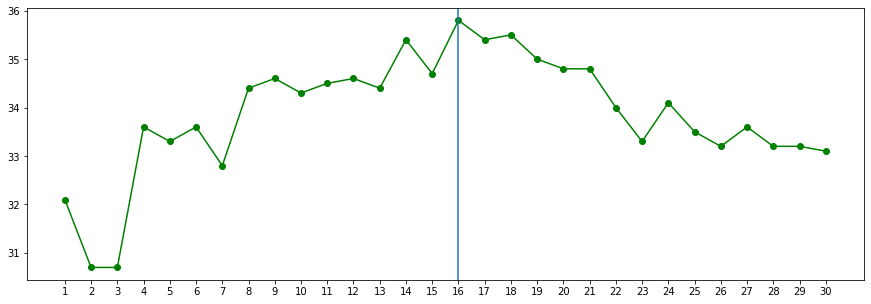

In [13]:
# Plotting the accuracy scores
plt.figure(figsize=(15,5))
plt.plot(range(1,31), acc_scores , '-go')
_ = plt.xticks(range(1,31))
plt.axvline(np.argmax(acc_scores) + 1)

1.   The accuracy score seems to be the best at 35.8% for k value of 16.
2.   Let's set the k value to 16 and train a model with the entire training dataset.

In [14]:
# Create the classifier model using the best k found among 30 iterations
st = time()
clf = KNeighborsClassifier(n_neighbors= np.argmax(acc_scores) + 1)
clf.fit(X_train, y_train_df)

predictions = clf.predict(X_test)
print('Time taken:', time()-st)

Time taken: 1348.7648289203644


In [15]:
# Classification Report
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test_df, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.44      0.69      0.54      1814
           1       0.47      0.73      0.57      1828
           2       0.61      0.55      0.58      1803
           3       0.45      0.43      0.44      1719
           4       0.66      0.65      0.65      1812
           5       0.51      0.39      0.44      1768
           6       0.49      0.41      0.44      1832
           7       0.71      0.62      0.66      1808
           8       0.46      0.36      0.40      1812
           9       0.56      0.42      0.48      1804

    accuracy                           0.53     18000
   macro avg       0.54      0.52      0.52     18000
weighted avg       0.54      0.53      0.52     18000





**Neural Network Model**


In [0]:
# Generic method to Build the Neural Network
def NNModel(layers):
    # Create model
    network = Sequential()
    # Add the layers
    if layers:
        for layer in layers:
            network.add(layer['layer_type'](**layer['params']))
    return network

<h4>Initialize Tensorboard callback for visualization of training</h4>

In [0]:
# Setting the directory to store the log file
# tb_callback = callbacks.TensorBoard(log_dir='.logs/{}'.format(time()), 
#                                     histogram_freq=0, 
#                                     write_graph=True, 
#                                     write_images=True)

<h4>Initialize Early Stopping and Model Checkpoint callbacks</h4>

In [0]:
# Stop if the val_loss is not changing even 0.001 for more than 10 continious epochs
es_callback = callbacks.EarlyStopping(monitor='val_loss', 
                                      min_delta=0.001, 
                                      patience=10)

## Iteration - 1


In [0]:
# Define the layers for Iteration - 1
layers = [
    {
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_df)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model1 = NNModel(layers)

<h4>Set Optimizer and Loss function for training</h4>

In [0]:
learning_rate = 5e-3
momentum = 2e-2

# Optimizer = SGD, Loss function = Categorical cross entropy
model1.compile(optimizer = optimizers.SGD(learning_rate, momentum), 
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [20]:
epochs = 30
batch_size = 200

# Start training the network
st = time()
model1.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 42000 samples, validate on 60000 samples
Epoch 1/30
42000/42000 - 3s - loss: 2.3063 - acc: 0.1024 - val_loss: 2.2984 - val_acc: 0.1080
Epoch 2/30
42000/42000 - 1s - loss: 2.2951 - acc: 0.1175 - val_loss: 2.2916 - val_acc: 0.1255
Epoch 3/30
42000/42000 - 1s - loss: 2.2891 - acc: 0.1322 - val_loss: 2.2863 - val_acc: 0.1438
Epoch 4/30
42000/42000 - 1s - loss: 2.2836 - acc: 0.1459 - val_loss: 2.2808 - val_acc: 0.1525
Epoch 5/30
42000/42000 - 1s - loss: 2.2774 - acc: 0.1581 - val_loss: 2.2739 - val_acc: 0.1686
Epoch 6/30
42000/42000 - 1s - loss: 2.2703 - acc: 0.1735 - val_loss: 2.2663 - val_acc: 0.1851
Epoch 7/30
42000/42000 - 1s - loss: 2.2621 - acc: 0.1895 - val_loss: 2.2573 - val_acc: 0.2093
Epoch 8/30
42000/42000 - 1s - loss: 2.2522 - acc: 0.2090 - val_loss: 2.2470 - val_acc: 0.2174
Epoch 9/30
42000/42000 - 1s - loss: 2.2405 - acc: 0.2284 - val_loss: 2.2340 - val_acc: 0.2417
Epoch 10/30
42000/42000

In [21]:
# Print the Summary of the Network
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  262400    
_________________________________________________________________
dense_1 (Dense)              multiple                  16448     
_________________________________________________________________
dense_2 (Dense)              multiple                  4160      
_________________________________________________________________
dense_3 (Dense)              multiple                  650       
Total params: 283,658
Trainable params: 283,658
Non-trainable params: 0
_________________________________________________________________




## Iteration - 2


In [0]:
# Define the layers for Iteration - 2
layers = [
    {
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (1024,)
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.25
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (256,)
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.2
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 32,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_df)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model2 = NNModel(layers)

<h4>Set Optimizer and Loss function for training</h4>

In [0]:
learning_rate = 1e-3

# Optimizer = Adam, Loss function = Categorical cross entropy
model2.compile(optimizer = optimizers.Adam(lr=learning_rate),
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [0]:
epochs = 30
batch_size = 150

# Start training the network
st = time()
model2.fit(X_train, y_train, 
          validation_data=(X_val, y_val),
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Train on 42000 samples, validate on 60000 samples
Epoch 1/30
42000/42000 - 2s - loss: 1.7131 - acc: 0.4030 - val_loss: 1.2458 - val_acc: 0.6332
Epoch 2/30
42000/42000 - 2s - loss: 1.2068 - acc: 0.6100 - val_loss: 0.9000 - val_acc: 0.7271
Epoch 3/30
42000/42000 - 2s - loss: 1.0499 - acc: 0.6644 - val_loss: 0.7830 - val_acc: 0.7561
Epoch 4/30
42000/42000 - 2s - loss: 0.9496 - acc: 0.6928 - val_loss: 0.7184 - val_acc: 0.7782
Epoch 5/30
42000/42000 - 2s - loss: 0.8882 - acc: 0.7145 - val_loss: 0.7102 - val_acc: 0.7831
Epoch 6/30
42000/42000 - 2s - loss: 0.8373 - acc: 0.7324 - val_loss: 0.6240 - val_acc: 0.8087
Epoch 7/30
42000/42000 - 2s - loss: 0.8054 - acc: 0.7415 - val_loss: 0.5933 - val_acc: 0.8195
Epoch 8/30
42000/42000 - 2s - loss: 0.7700 - acc: 0.7528 - val_loss: 0.5812 - val_acc: 0.8208
Epoch 9/30
42000/42000 - 2s - loss: 0.7361 - acc: 0.7645 - val_loss: 0.5500 - val_acc: 0.8317
Epoch 10/30
42000/42000 - 2s - loss: 0.7188 - acc: 0.7677 - val_loss: 0.5224 - val_acc: 0.8425
Epoch 11/

In [0]:
# Print the Summary of the Network
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)               



## Iteration - 3


In [0]:
# Define the layers for Iteration - 3
layers = [
    {
        'layer_type': BatchNormalization,
        'params': {
            'input_shape': (1024,)
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 256,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 64,
            'activation': 'relu'
        }
    },{
        'layer_type': Dropout,
        'params': {
            'rate': 0.2
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': 32,
            'activation': 'relu'
        }
    },{
        'layer_type': Dense,
        'params': {
            'units': len(np.unique(y_train_df)),
            'activation': 'softmax'
        }
    }
]

# Build network architecture
model3 = NNModel(layers)

<h4>Set Optimizer and Loss function for training</h4>

In [0]:
learning_rate = 1e-3

# Optimizer = Adam, Loss function = Categorical cross entropy
model3.compile(optimizer = optimizers.Adam(lr=learning_rate), 
              loss = losses.categorical_crossentropy, 
              metrics=['accuracy'])

<h4>Train the network</h4>

In [0]:
epochs = 50
batch_size = 150
# Start training the network
st = time()
model3.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size, 
          verbose=2,
          callbacks=[es_callback])
print('\nTotal time taken:', time()-st)

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 - 2s - loss: 1.6198 - acc: 0.4439 - val_loss: 1.1803 - val_acc: 0.6740
Epoch 2/50
42000/42000 - 2s - loss: 1.0819 - acc: 0.6554 - val_loss: 0.8264 - val_acc: 0.7509
Epoch 3/50
42000/42000 - 2s - loss: 0.9197 - acc: 0.7091 - val_loss: 0.7694 - val_acc: 0.7607
Epoch 4/50
42000/42000 - 2s - loss: 0.8309 - acc: 0.7367 - val_loss: 0.6612 - val_acc: 0.7988
Epoch 5/50
42000/42000 - 2s - loss: 0.7698 - acc: 0.7583 - val_loss: 0.6457 - val_acc: 0.8001
Epoch 6/50
42000/42000 - 2s - loss: 0.7181 - acc: 0.7733 - val_loss: 0.5966 - val_acc: 0.8160
Epoch 7/50
42000/42000 - 2s - loss: 0.6763 - acc: 0.7841 - val_loss: 0.5548 - val_acc: 0.8321
Epoch 8/50
42000/42000 - 2s - loss: 0.6475 - acc: 0.7953 - val_loss: 0.5181 - val_acc: 0.8422
Epoch 9/50
42000/42000 - 2s - loss: 0.6201 - acc: 0.8047 - val_loss: 0.5204 - val_acc: 0.8399
Epoch 10/50
42000/42000 - 2s - loss: 0.5876 - acc: 0.8140 - val_loss: 0.5164 - val_acc: 0.8421
Epoch 11/

In [0]:
# Print the Summary of the Network
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_9 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 285,354
Trainable params: 283,306
Non-trainable params: 2,048
____________________________________________


## <u>Evaluate the Neural Network</u>



In [0]:
# Testing the model on test set
predictions = model3.predict_classes(X_test)
score = model3.evaluate(X_test, y_test)
print('Test loss      :', score[0])
print('Test accuracy  :', score[1])

18000/18000 [==============================] - 1s 52us/sample - loss: 0.5645 - acc: 0.8546
Test loss      : 0.5645428023404545
Test accuracy  : 0.8546111


In [0]:
# Classification Report
print("EVALUATION ON TESTING DATA")
print(classification_report(y_test_df, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1814
           1       0.83      0.88      0.86      1828
           2       0.85      0.87      0.86      1803
           3       0.84      0.82      0.83      1719
           4       0.91      0.86      0.88      1812
           5       0.85      0.83      0.84      1768
           6       0.82      0.86      0.84      1832
           7       0.86      0.89      0.88      1808
           8       0.86      0.78      0.82      1812
           9       0.84      0.86      0.85      1804

    accuracy                           0.85     18000
   macro avg       0.86      0.85      0.85     18000
weighted avg       0.86      0.85      0.85     18000



<h4>Visualizing some predictions</h4>

Actual labels corresponding to below images: [1 7 2 9 0 9 1 8 4 4 8 9 1 4 3]
Predicted labels corresponding to below images: [1 7 2 9 0 9 1 8 1 4 8 2 1 4 3]


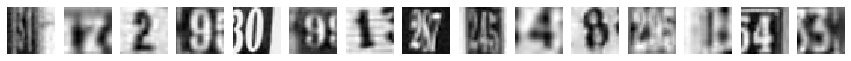

In [0]:
# visualizing the first 15 images in the dataset and their labels
print('Actual labels corresponding to below images: %s' % (y_test_df[0:15]))
plt.figure(figsize=(15, 1))
for i in range(15):
    plt.subplot(1, 15, i+1)
    plt.imshow(X_test_df[i], cmap="gray")
    plt.axis('off')
    
print('Predicted labels corresponding to below images: %s' % (predictions[0:15]))